# PyEumap - EML Land Cover Mapping, Uncertainty Estimation and AutoML

Following the [land cover mapping tutorial](https://gitlab.com/geoharmonizer_inea/eumap/-/blob/master/demo/python/03_landcover_mapping.ipynb), we will do the same with two different custom ensemble models, as well as produce an estimate of classification uncertainty.

## Ensemble ML

First, we will import the necessary modules and provide the overlay file path and feature/target column names:

In [1]:
import sys
sys.path.append('../../')

import os
import gdal
from pathlib import Path
import pandas as pd
import geopandas as gpd
from pyeumap.mapper import LandMapper
from pyeumap import datasets
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from mlens.ensemble import SuperLearner

fn_points = '../../overlay_spacetime.gpkg'
feat_col_prfxs = ['landsat', 'dtm', 'night_lights']
target_col = 'lc_class'

[MLENS] backend: threading


Now we will construct a stacked classifier ensemble using [`ml-ens`](http://ml-ensemble.com/) and train it on our data in an equivalent manner to training a single model.

In [2]:
stacked_ensemble = SuperLearner()
stacked_ensemble.add([
    RandomForestClassifier(),
    SVC(probability=True),
    KNeighborsClassifier(),
], proba=True)
stacked_ensemble.add_meta(GradientBoostingClassifier())

landmapper = LandMapper(
    fn_points, feat_col_prfxs, target_col,
    estimator=stacked_ensemble,
    val_samples_pct=0.5,
    min_samples_per_class=0.05,
    verbose=False
)

landmapper.train()
print(f'Overall accuracy: {landmapper.overall_acc * 100:.2f}%\n\n')
print(landmapper.classification_report)

Overall accuracy: 58.29%


              precision    recall  f1-score   support

       231.0       0.44      0.48      0.46        29
       312.0       0.54      0.68      0.60        95
       321.0       0.52      0.41      0.46        87
       322.0       0.27      0.31      0.29        45
       324.0       0.36      0.27      0.31        51
       332.0       0.71      0.61      0.66        49
       333.0       0.71      0.76      0.73       121
       335.0       0.98      0.85      0.91        48

    accuracy                           0.58       525
   macro avg       0.57      0.55      0.55       525
weighted avg       0.59      0.58      0.58       525



Next, we will construct a voting classifier ensemble using [`scikit-learn`](https://scikit-learn.org) and train it.

In [3]:
voting_ensemble = VotingClassifier([
    ('rf', RandomForestClassifier()),
    ('svm', SVC(probability=True)),
    ('knn', KNeighborsClassifier()),
    ('gbt', GradientBoostingClassifier()),
], voting='soft')

landmapper = LandMapper(
    fn_points, feat_col_prfxs, target_col,
    estimator=voting_ensemble,
    val_samples_pct=0.5,
    min_samples_per_class=0.05,
    verbose=False
)

landmapper.train()
print(f'Overall accuracy: {landmapper.overall_acc * 100:.2f}%\n\n')
print(landmapper.classification_report)

Overall accuracy: 67.05%


              precision    recall  f1-score   support

       231.0       0.95      0.58      0.72        33
       312.0       0.66      0.76      0.71       114
       321.0       0.58      0.79      0.67        77
       322.0       0.41      0.34      0.37        53
       324.0       0.53      0.20      0.30        44
       332.0       0.76      0.47      0.58        47
       333.0       0.72      0.83      0.77       118
       335.0       0.93      0.97      0.95        39

    accuracy                           0.67       525
   macro avg       0.69      0.62      0.63       525
weighted avg       0.67      0.67      0.65       525



## Uncertainty Estimation

With our second ensemble model we will produce predictions over the sample tile, as well as a classification uncertainty estimate.

In [4]:
tile = datasets.TILES[0]

data_root = datasets.DATA_ROOT_NAME
data_dir = Path(os.getcwd()).joinpath('../..', data_root, tile)

dir_timeless_layers = os.path.join(data_dir, 'timeless')
dir_2000_layers = os.path.join(data_dir, '2000')

dirs_layers = [dir_2000_layers, dir_timeless_layers]
fn_result = 'land_cover_2000.tif'
data_type = gdal.GDT_Int16

landmapper.predict(dirs_layers, fn_result, data_type, estimate_uncertainty=True)

Now we can visualize our predictions and uncertainty with the `pyeumap.plotter` module. The image on the right represents classification uncertainty (ranging from 0 - white to 100 - red), expressed as relative entropy of the class predictions (the ratio of the prediction entropy to the maximum possible entropy for the given number of classes).

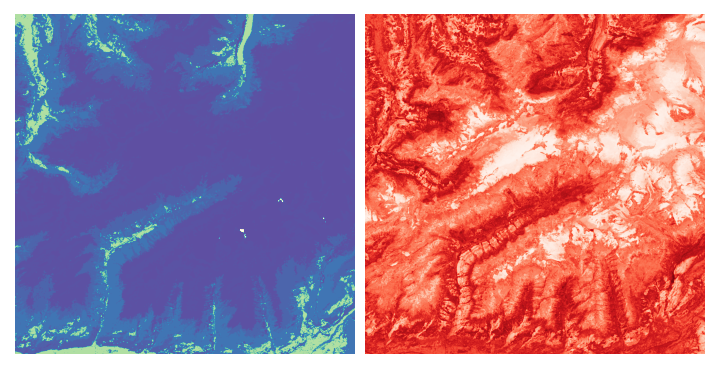

In [5]:
from pyeumap import plotter

plotter.plot_rasters(
    'land_cover_2000.tif',
    'land_cover_2000_uncertainty.tif',
    cmaps=['Spectral', 'Reds'],
    figsize=6,
)

## AutoML

If we omit the `estimator` argument to `LandMapper()`, `pyeumap` will search for an estimator automatically, using [`auto-sklearn`](https://automl.github.io/auto-sklearn), with additional keyword arguments being passed to the `auto-sklearn` estimator object:

In [3]:
landmapper = LandMapper(
    fn_points, feat_col_prfxs, target_col,
    val_samples_pct=0.5,
    min_samples_per_class=0.05,
    verbose=False,
    time_left_for_this_task=1800, # seconds
    n_jobs=8,
)

landmapper.train()
print(f'Overall accuracy: {landmapper.overall_acc * 100:.2f}%\n\n')
print(landmapper.classification_report)

[WARNING] [2020-12-17 15:12:59,258:AutoML(1):1c3456fe8f80ef9810dbfd2dc2b46df8] Capping the per_run_time_limit to 899.0 to have time for a least 2 models in each process.
Overall accuracy: 65.33%


              precision    recall  f1-score   support

       231.0       0.74      0.49      0.59        35
       312.0       0.70      0.68      0.69       104
       321.0       0.60      0.76      0.67        90
       322.0       0.38      0.50      0.43        56
       324.0       0.38      0.23      0.29        43
       332.0       0.82      0.57      0.67        49
       333.0       0.73      0.77      0.75       107
       335.0       0.95      0.95      0.95        41

    accuracy                           0.65       525
   macro avg       0.66      0.62      0.63       525
weighted avg       0.66      0.65      0.65       525

